<h1><b style="color:red">YOLO Algorithm</b> - Object Detection (Classfication + Regression)</h1>

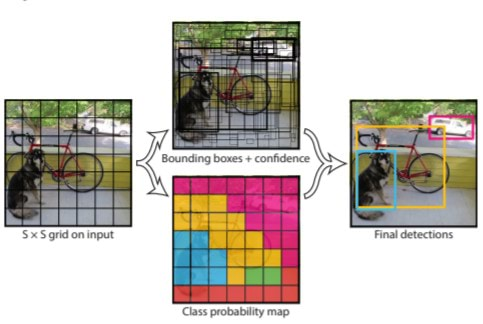
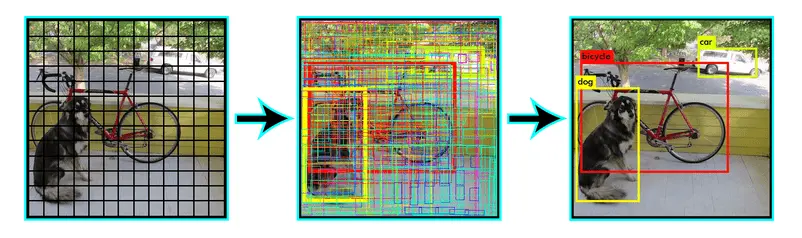
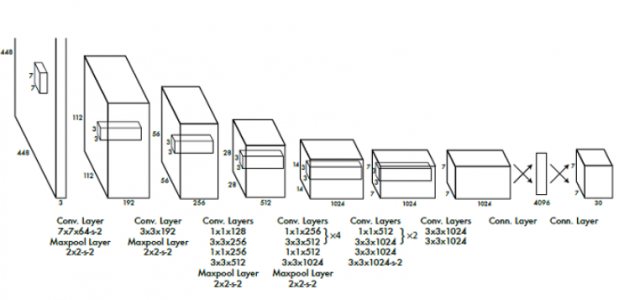
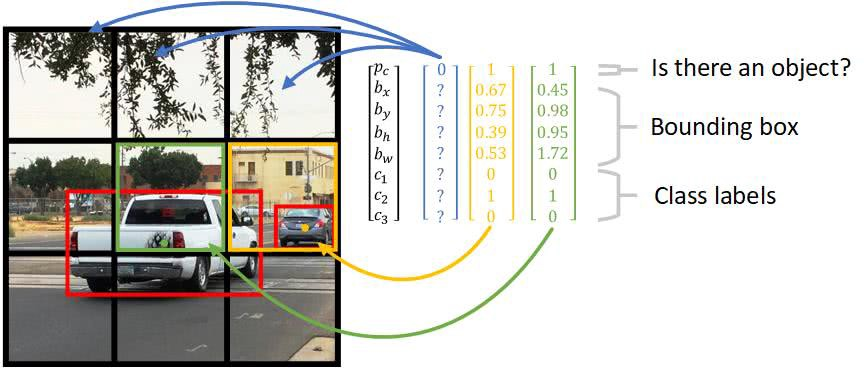

<h3>Importing libraries:</h3>

In [3]:
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
import cv2
import wget
import os
import copy

In [4]:
# Downloading YOLO configuration.
if not os.path.exists("utils/yolov3.cfg"):
    wget.download("https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.cfg", out="utils/yolov3.cfg")

# Downloading YOLO model weights/ trained.
if not os.path.exists("utils/yolov3.weights"):
    wget.download("https://pjreddie.com/media/files/yolov3.weights", out="utils/yolov3.weights")
    
# Downloading COCO data set/classes.
if not os.path.exists("utils/coco_classes.txt"): # plik z klasami w zestawie danych COCO
    wget.download("https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.txt", out="utils/coco_classes.txt")

# Extracting coco classes to the data structure/ list.
with open("utils/coco_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]
print(f"Classes: \n{classes}")

Classes: 
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


Colors: 
[[196.68676403   5.29174709 161.58029991]
 [190.94499005 127.11928814  57.32314461]
 [ 50.50603051 193.93533161  43.12326332]
 [ 22.52665261 174.76675368 243.11530328]
 [  1.00680791 130.60902716 207.21834522]
 [156.19414704 184.04760595  74.42839738]
 [234.03240124 182.21682477 138.34881384]
 [ 36.25336214  95.20189381 171.90407184]
 [112.66745948 110.6735683  157.53057951]
 [130.85025185 165.85128139 153.26493312]
 [205.33191519 133.02002386 231.70546461]
 [ 81.40520269  23.06713406  76.67851444]
 [ 29.06601228 211.31373821  11.95856144]
 [159.70322282 139.63446976 208.9181839 ]
 [ 50.73162262 218.49682713  89.67142306]
 [192.43516134  75.47023525 225.40380229]
 [ 83.00546765  42.07905392 100.09495721]
 [ 23.83239551 209.38194275  38.54376501]
 [ 97.94918442 240.78648162 251.8444961 ]
 [116.35765951 210.66132518  64.10040422]
 [152.3297703  230.22209888 136.31227694]
 [150.50134756  10.01685064  91.08134845]
 [ 20.30133799  77.89227918  84.33342456]
 [197.32672553  10.189598


Image dimension: (1546, 1213)

Image width: 1546, height: 1213



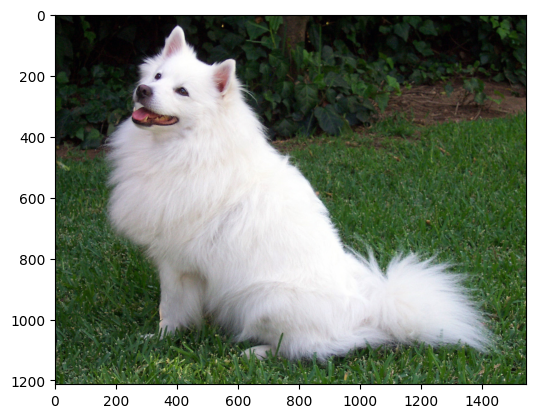

In [5]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))
if not os.path.exists("utils/dog.jpg"):
    wget.download("https://github.com/pytorch/hub/raw/master/images/dog.jpg", out="utils/dog.jpg")
print(f"Colors: \n{colors}")

# Creating YOLO CNN Model.
yolo_model = cv2.dnn.readNet("utils/yolov3.weights", "utils/yolov3.cfg") # Weights and configuration.
layers = yolo_model.getLayerNames()
output_layers = [layers[i - 1] for i in yolo_model.getUnconnectedOutLayers()]

image = cv2.imread("utils/dog.jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
img_dim = (image.shape[1], image.shape[0])
input_img = cv2.dnn.blobFromImage(
    image=image,
    scalefactor=1/255,  # Scaling. 
    size=(416,416),     # Resizing.
    mean=(0,0,0), 
    swapRB=True, 
    crop=False)

print(f"\nImage dimension: {img_dim}\n")
print(f"Image width: {img_dim[0]}, height: {img_dim[1]}\n")

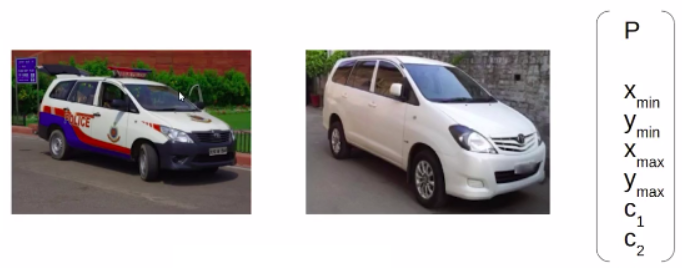
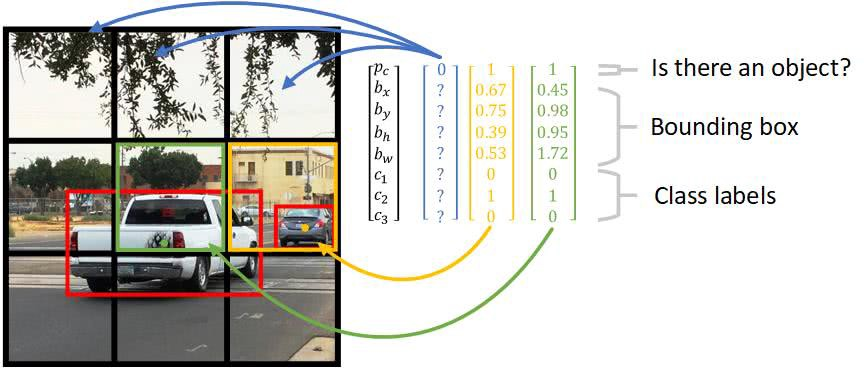

In [6]:
def print_bounding_box(bounding_box):
    print("Bounding box: ")
    print(f"[ Ci = {'%.2f' % float(bounding_box[0])} ]")
    print(f"[ Pc = {'%.2f' % float(bounding_box[1])} ]")
    print(f"[ Bx = {'%.2f' % float(bounding_box[2])} ]")
    print(f"[ By = {'%.2f' % float(bounding_box[3])} ]")
    print(f"[ Bw = {'%.2f' % float(bounding_box[4])} ]")
    print(f"[ By = {'%.2f' % float(bounding_box[5])} ]")

def yolo_predict(yolo_model, input_img, img_dim, output_layers, classes, debug=True):
    yolo_model.setInput(input_img)
    outputs = yolo_model.forward(output_layers)
    objects_detected = []
    for output in outputs:
        for detection in output:
            classes_scores = detection[5:]
            box_width = int(detection[2] * img_dim[0])
            box_height = int(detection[3] * img_dim[1])
            box_x = int(detection[0] * img_dim[0] - 0.5 * box_width)
            box_y = int(detection[1] * img_dim[1] - 0.5 * box_height)
            class_ID = np.argmax(classes_scores)
            confidence = max(classes_scores)

            if confidence > 0.5:
                bounding_box = np.zeros((6))
                bounding_box[0] = class_ID
                bounding_box[1] = confidence
                bounding_box[2] = box_x
                bounding_box[3] = box_y
                bounding_box[4] = box_width
                bounding_box[5] = box_height
                if debug:
                    print(f"------------------------")
                    print(f"Class ID: {class_ID}")
                    print(f"Class name: {classes[class_ID]}")
                    print(f"Confidence: {confidence}")
                    print(f"Box x: {box_x}")
                    print(f"Box y: {box_y}")
                    print(f"Box width: {box_width}")
                    print(f"Box height: {box_height}")
                    print_bounding_box(bounding_box)
                    print(f"-------------------------")
                objects_detected.append(bounding_box)
                print(f"Detected: {classes[class_ID]}, {confidence} confidence, ({bounding_box[2]}, {bounding_box[3]}), {bounding_box[4]} x {bounding_box[5]}")
    return objects_detected

In [7]:
objects_detected = yolo_predict(
    yolo_model = yolo_model,
    input_img=input_img,
    img_dim=img_dim,
    output_layers=output_layers,
    classes=classes,
    debug=True
)

------------------------
Class ID: 16
Class name: dog
Confidence: 0.8348475098609924
Box x: 201
Box y: 61
Box width: 1182
Box height: 976
Bounding box: 
[ Ci = 16.00 ]
[ Pc = 0.83 ]
[ Bx = 201.00 ]
[ By = 61.00 ]
[ Bw = 1182.00 ]
[ By = 976.00 ]
-------------------------
Detected: dog, 0.8348475098609924 confidence, (201.0, 61.0), 1182.0 x 976.0
------------------------
Class ID: 16
Class name: dog
Confidence: 0.5482625365257263
Box x: 267
Box y: 95
Box width: 1160
Box height: 909
Bounding box: 
[ Ci = 16.00 ]
[ Pc = 0.55 ]
[ Bx = 267.00 ]
[ By = 95.00 ]
[ Bw = 1160.00 ]
[ By = 909.00 ]
-------------------------
Detected: dog, 0.5482625365257263 confidence, (267.0, 95.0), 1160.0 x 909.0
------------------------
Class ID: 16
Class name: dog
Confidence: 0.5595223307609558
Box x: 78
Box y: 79
Box width: 1244
Box height: 1011
Bounding box: 
[ Ci = 16.00 ]
[ Pc = 0.56 ]
[ Bx = 78.00 ]
[ By = 79.00 ]
[ Bw = 1244.00 ]
[ By = 1011.00 ]
-------------------------
Detected: dog, 0.559522330760955

In [8]:
objects_detected = yolo_predict(
    yolo_model=yolo_model,
    input_img=input_img,
    img_dim=img_dim,
    output_layers=output_layers,
    classes=classes,
    debug=False
)

Detected: dog, 0.8348475098609924 confidence, (201.0, 61.0), 1182.0 x 976.0
Detected: dog, 0.5482625365257263 confidence, (267.0, 95.0), 1160.0 x 909.0
Detected: dog, 0.5595223307609558 confidence, (78.0, 79.0), 1244.0 x 1011.0
Detected: dog, 0.957431972026825 confidence, (179.0, 50.0), 1208.0 x 1071.0
Detected: dog, 0.902737021446228 confidence, (222.0, 87.0), 1247.0 x 1012.0


<h3>Drawing bounding boxes</h3>

In [9]:
def draw_bounding_boxes(image, objects_detected, colors):
    for object in objects_detected:
        b_x = int(object[2])
        b_y = int(object[3])
        b_width = int(object[4])
        b_height = int(object[5])
        cv2.line(
            img=image,
            pt1=(b_x, b_y),
            pt2=(b_x+b_width, b_y),
            color=colors[int(object[0])],
            thickness=3
        )
        cv2.line(
            img=image,
            pt1=(b_x, b_y),
            pt2=(b_x, b_y+b_height),
            color=colors[int(object[0])],
            thickness=3
        )
        cv2.line(
            img=image,
            pt1=(b_x, b_y+b_height),
            pt2=(b_x+b_width, b_y+b_height),
            color=colors[int(object[0])],
            thickness=3
        )
        cv2.line(
            img=image,
            pt1=(b_x+b_width, b_y),
            pt2=(b_x+b_width, b_y+b_height),
            color=colors[int(object[0])],
            thickness=3
        )
        cv2.putText(
            img=image,
            text=classes[int(object[0])]+", "+str(object[1]),
            org=(int(object[2]), int(object[3])),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=colors[int(object[0])],
            thickness=3
        )
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

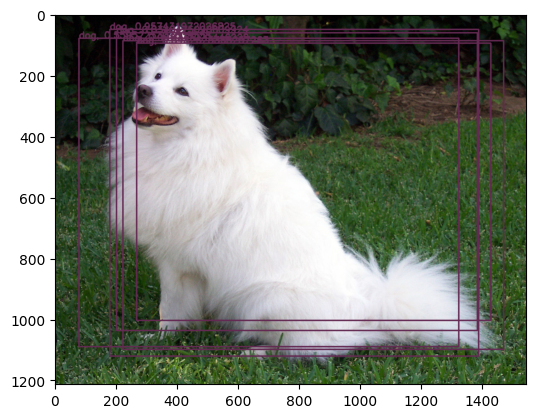

In [10]:
draw_bounding_boxes(copy.deepcopy(image), objects_detected, colors)

<h3>Non-Max Suppresion implementation for YOLO CNN Model</h3>

\begin{equation*}
    \textrm{IoU} = \frac{\textrm{intersection of areas}}{\textrm{summary of areas}}
\end{equation*}

In [11]:
def compute_iou(bounding_box_1, bounding_box_2):
    b1_x, b1_y, b1_width, b1_height = bounding_box_1[2:6]
    b2_x, b2_y, b2_width, b2_height = bounding_box_2[2:6]

    b1_x_min = b1_x
    b1_y_min = b1_y
    b1_x_max = b1_x + b1_width
    b1_y_max = b1_y + b1_height
    
    b2_x_min = b2_x
    b2_y_min = b2_y
    b2_x_max = b2_x + b2_width
    b2_y_max = b2_y + b2_height
    
    x_overlap = max(0, min(b1_x_max, b2_x_max) - max(b1_x_min, b2_x_min))
    y_overlap = max(0, min(b1_y_max, b2_y_max) - max(b1_y_min, b2_y_min))

    intersection = x_overlap * y_overlap
    union = b1_width * b1_height + b2_width * b2_height - intersection

    iou = intersection / union if union > 0 else 0

    return iou

In [12]:
# Test IoU
iou = compute_iou((0,0,0,0,4,2),(0,0,2,1,4,2))
print("Przykładowa wartość obliczonego IoU dla bboxów (0,0,0,0,4,2),(0,0,2,1,4,2): " + str(iou))

Przykładowa wartość obliczonego IoU dla bboxów (0,0,0,0,4,2),(0,0,2,1,4,2): 0.14285714285714285


In [13]:
def sort_objects(objects_detected, column_id):
    number_of_objects = len(objects_detected)
    sorted_objects = {}
    for object, i in zip(objects_detected, range(number_of_objects)):
        sorted_objects[i]=object[column_id]
    sorted_objects = sorted(sorted_objects.items(), key=lambda x: x[1], reverse=True)
    final_sorted_objects = []
    for object in sorted_objects:
        final_sorted_objects.append(list(objects_detected[object[0]]))
    return final_sorted_objects
    
def get_classes(classes, column_id, class_id):
    result = []
    for record in classes:
        if record[column_id] == class_id:
            result.append(record)
    return result

def perform_nms(objects_detected, debug=True):
    objects_detected = np.array(sort_objects(objects_detected, column_id=1))
    objects_detected_supp = []
    
    for class_id in set(objects_detected[:, 0]):
        objects_class = np.array(get_classes(objects_detected, 0, class_id))
        while objects_class.shape[0]>0:
            currently_most_confident = objects_class[0]
            objects_detected_supp.append(currently_most_confident)
            objects_class = objects_class[1:]
            indices_to_delete = []
            for id in range(objects_class.shape[0]):
                other = objects_class[id]
                iou = compute_iou(currently_most_confident, other)
                print(f"IOU: {'%.10f'%iou}")
                if iou > 0.5:
                    indices_to_delete.append(id)
            for delete_id in indices_to_delete:
                objects_class = np.array(get_classes(objects_class, 0, delete_id))
    return objects_detected_supp

IOU: 0.8563488559
IOU: 0.8916838258
IOU: 0.8278461099
IOU: 0.7654000217


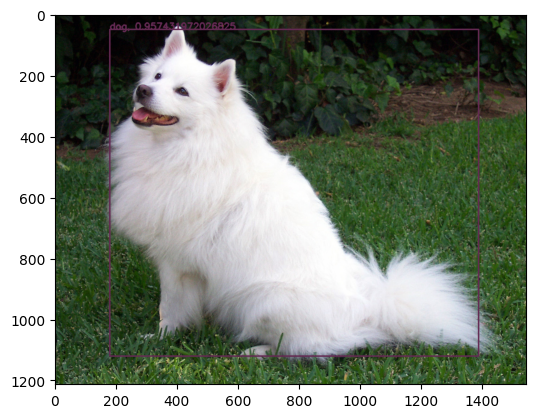

In [14]:
# Usuń zbędne bounding boxy i wyświetl obrazek z detekcjami ponownie
objects_detected_supp = perform_nms(objects_detected)
draw_bounding_boxes(copy.deepcopy(image), objects_detected_supp, colors)

# 5. Pytania kontrolne
1. Na czym polega problem detekcji obiektów i z jakich składowych problemów się składa?

Odp.: Problem detekcji obiektów składa się z klasyfikacji oraz regresji. Na początku klasyfikuję się obiekt, czy należy do jakiejś klasy (np.: kot lub pies), następnie przewiduję/ dokonuję się regresji, żeby określić prostokąt go otaczający.

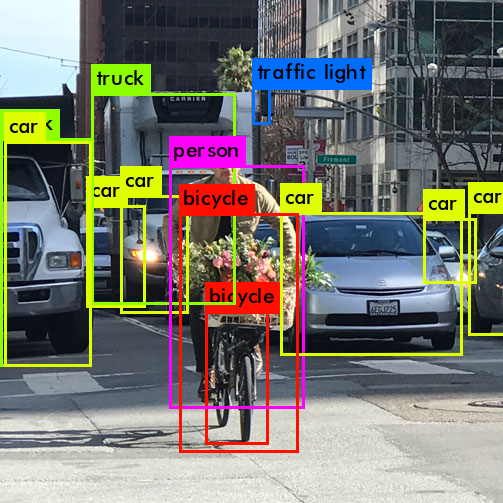

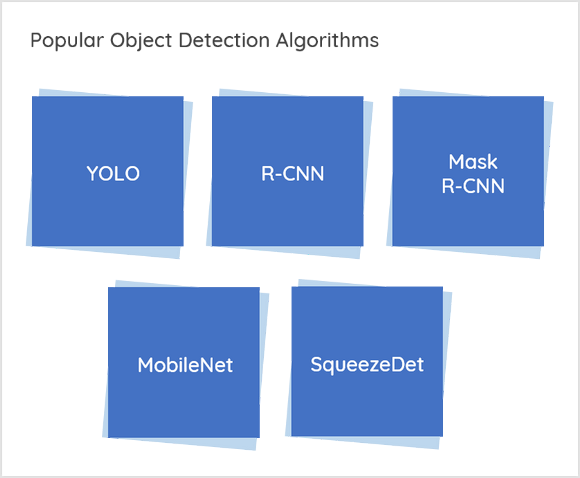

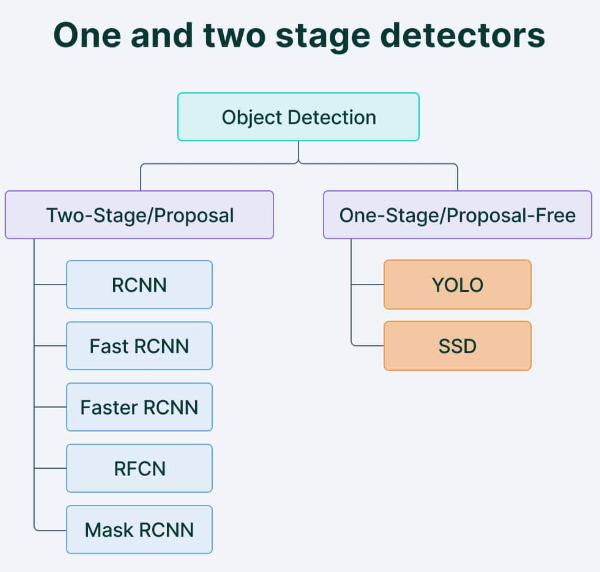

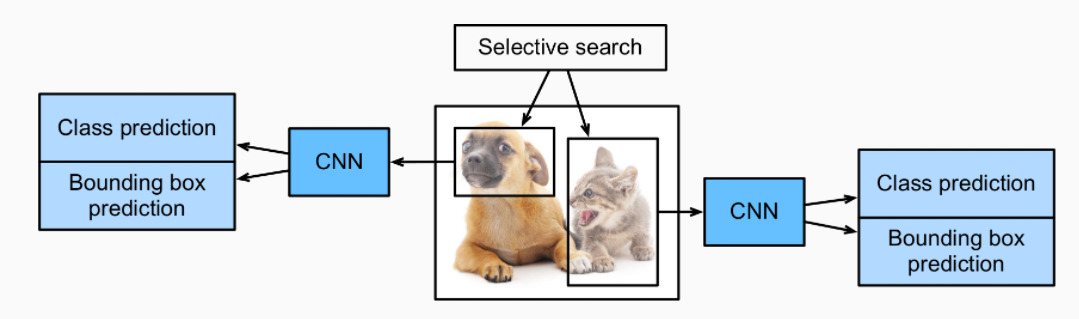

2. Opisz, jak działa algorytm YOLO.

Odp.: Algorytm YOLO przetwarza obraz tylko jeden raz, nie wykonuje rekurencji. Dzieli obrazek na fragmenty wykorzystując siatkę, a następnie tworzy odpowiednie wektor, które przedstawią lokalizację oraz prostokąty określające obiekty.

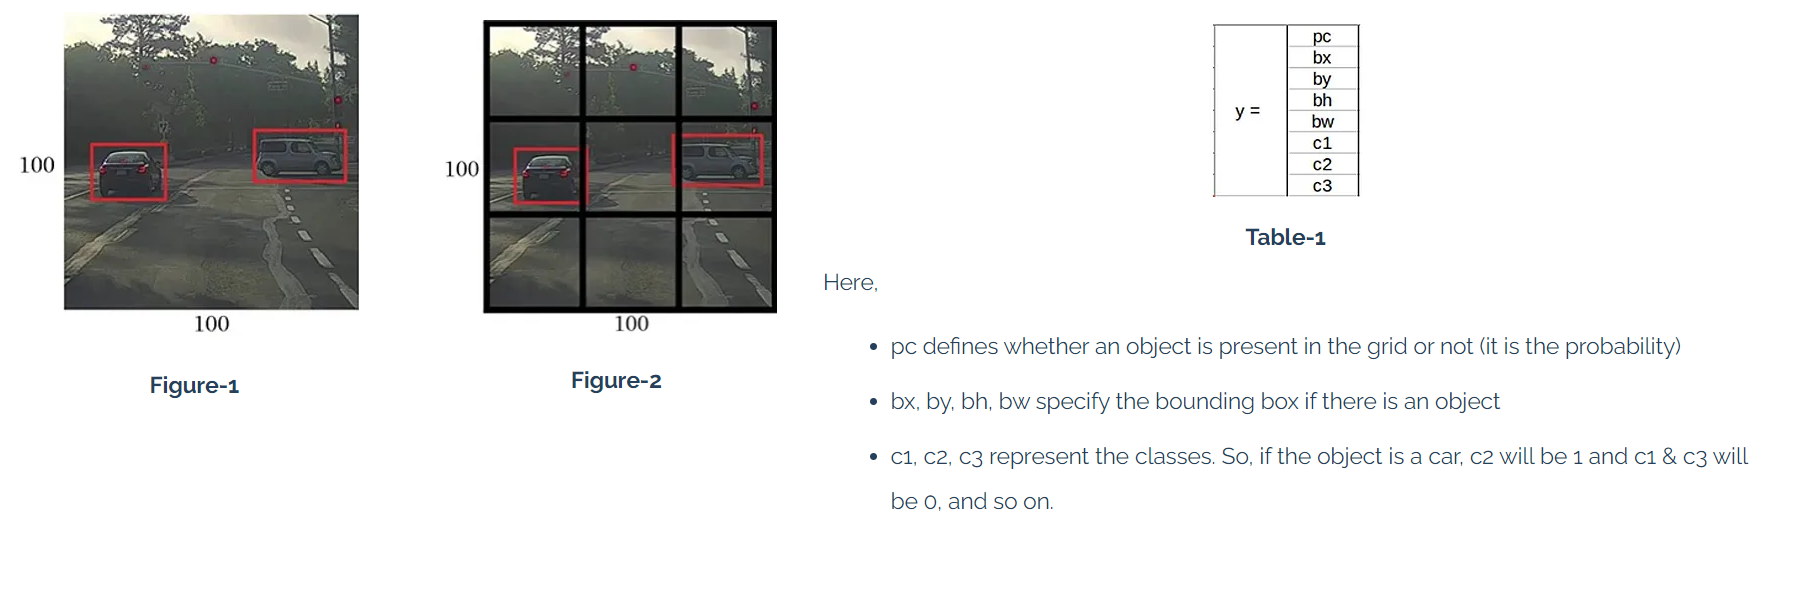

3. Na czym polega i po co stosowana jest metoda *Non-Max Suppression*?

Odp.: Metoda Non-Max Suppression jest stosowana do znajdywanie najlepszego prostokąta, który pokazuje obiekt na obrazku. Implementowana/ stosowana jest gdy otrzymamy bardzo wiele nachodzących na siebie prostokątów.

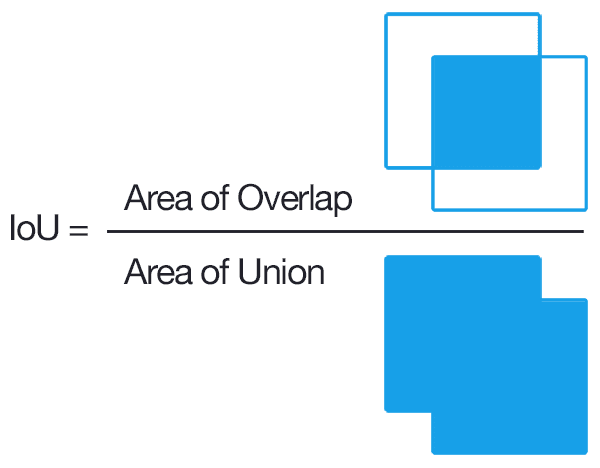
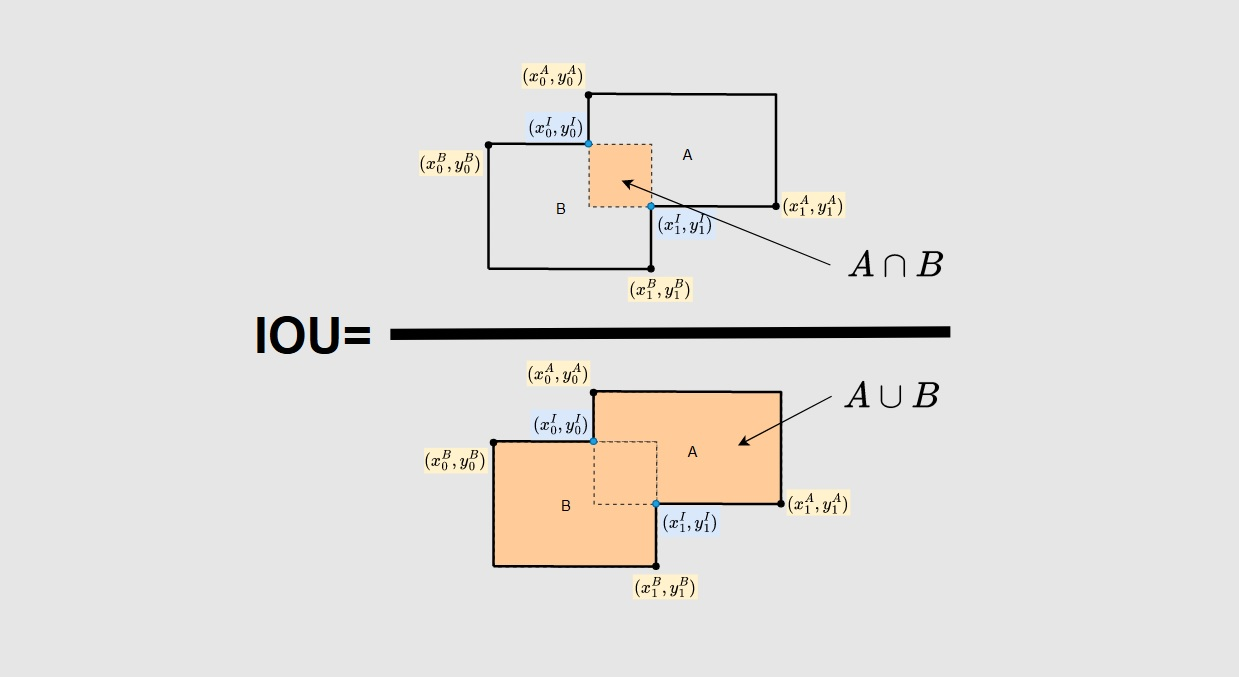
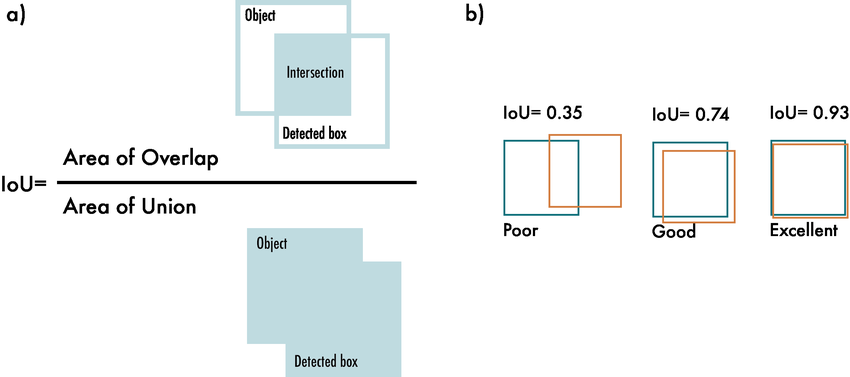